<a href="https://www.kaggle.com/code/gamzebayir/titanic-prediction?scriptVersionId=94144377" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error



from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingRegressor

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [4]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')
df = pd.concat([train, test], sort=False)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = the total number of variables
        num_but_cat is inside cat_cols.
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car =grab_col_names(df)


Observations: 1309
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [8]:
print(f" cat_cols: {cat_cols}\n num_cols: {num_cols} \n cat_but_car: {cat_but_car}")
df[num_cols].describe().T

 cat_cols: ['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']
 num_cols: ['PassengerId', 'Age', 'Fare'] 
 cat_but_car: ['Name', 'Ticket', 'Cabin']


,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


In [9]:
for i in num_cols:
    print(f"{i} :\n{df.groupby('Survived')[i].mean()}\n")

PassengerId :
Survived
0.0    447.016393
1.0    444.368421
Name: PassengerId, dtype: float64

Age :
Survived
0.0    30.626179
1.0    28.343690
Name: Age, dtype: float64

Fare :
Survived
0.0    22.117887
1.0    48.395408
Name: Fare, dtype: float64



In [10]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [11]:
for col in cat_cols:
    cat_summary(df, col)

        Sex      Ratio
male    843  64.400306
female  466  35.599694
   Embarked      Ratio
S       914  69.824293
C       270  20.626432
Q       123   9.396486
     Survived      Ratio
0.0       549  41.940413
1.0       342  26.126814
   Pclass      Ratio
3     709  54.163484
1     323  24.675325
2     277  21.161192
   SibSp      Ratio
0    891  68.067227
1    319  24.369748
2     42   3.208556
4     22   1.680672
3     20   1.527884
8      9   0.687548
5      6   0.458365
   Parch      Ratio
0   1002  76.546982
1    170  12.987013
2    113   8.632544
3      8   0.611154
5      6   0.458365
4      6   0.458365
6      2   0.152788
9      2   0.152788


In [12]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

In [13]:
for col in num_cols:
    num_summary(df, col)

count    1309.000000
mean      655.000000
std       378.020061
min         1.000000
5%         66.400000
10%       131.800000
20%       262.600000
30%       393.400000
40%       524.200000
50%       655.000000
60%       785.800000
70%       916.600000
80%      1047.400000
90%      1178.200000
95%      1243.600000
99%      1295.920000
max      1309.000000
Name: PassengerId, dtype: float64
#####################################
count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
5%          5.000000
10%        14.000000
20%        19.000000
30%        22.000000
40%        25.000000
50%        28.000000
60%        31.000000
70%        36.000000
80%        42.000000
90%        50.000000
95%        57.000000
99%        65.000000
max        80.000000
Name: Age, dtype: float64
#####################################
count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
5%          7.225000
10%         7.567500
20%         7.854200
30%

In [14]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [15]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

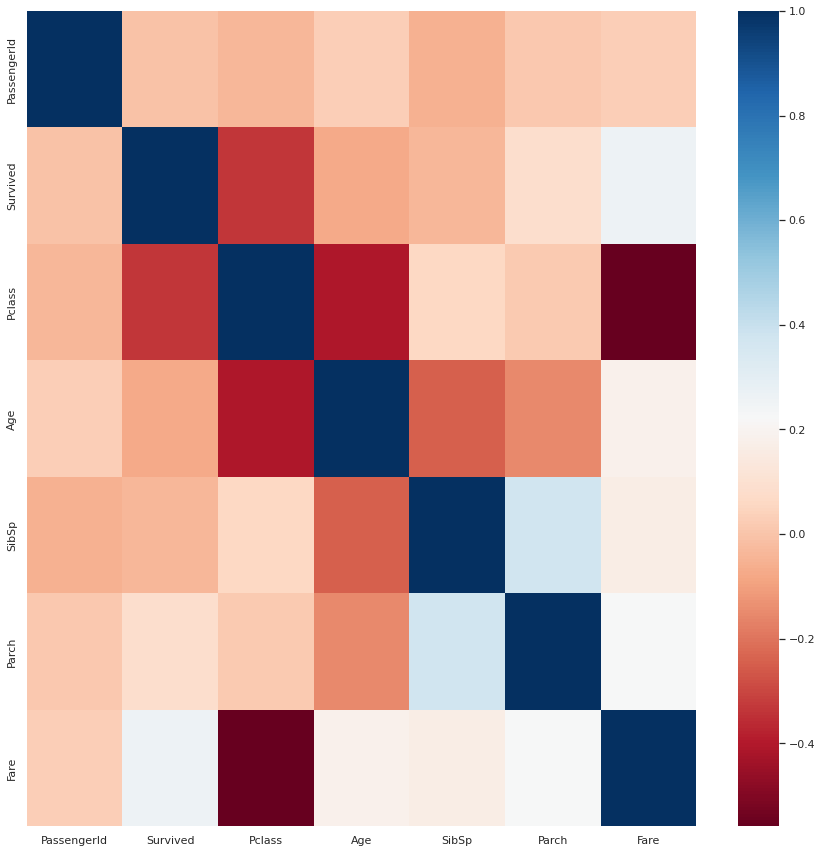

[]

In [16]:
high_correlated_cols(df, plot=True)

In [17]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [18]:
for i in num_cols:
    low, up = outlier_thresholds(df, i)
    if ((df[i] < low) | (df[i] > up)).any():
        print(f"\nIndices: {df[(df[i] < low) | (df[i] > up)].index}\n")
        print(df[(df[i] < low) | (df[i] > up)].head())
        replace_with_thresholds(df, i)





Indices: Int64Index([258, 679, 737, 343], dtype='int64')

     PassengerId  Survived  Pclass  \
258          259       1.0       1   
679          680       1.0       1   
737          738       1.0       1   
343         1235       NaN       1   

                                                  Name     Sex   Age  SibSp  \
258                                   Ward, Miss. Anna  female  35.0      0   
679                 Cardeza, Mr. Thomas Drake Martinez    male  36.0      0   
737                             Lesurer, Mr. Gustave J    male  35.0      0   
343  Cardeza, Mrs. James Warburton Martinez (Charlo...  female  58.0      0   

     Parch    Ticket      Fare        Cabin Embarked  
258      0  PC 17755  512.3292          NaN        C  
679      1  PC 17755  512.3292  B51 B53 B55        C  
737      0  PC 17755  512.3292         B101        C  
343      1  PC 17755  512.3292  B51 B53 B55        C  


In [19]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [20]:
na_cols=missing_values_table(df, True)

df.shape

          n_miss  ratio
Cabin       1014  77.46
Survived     418  31.93
Age          263  20.09
Embarked       2   0.15
Fare           1   0.08


(1309, 12)

In [21]:
def feature_extract(dataframe):
    dataframe.loc[((dataframe['SibSp'] + dataframe['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
    dataframe.loc[((dataframe['SibSp'] + dataframe['Parch']) == 0), "NEW_IS_ALONE"] = "YES"
    dataframe["Cabin_new"]=dataframe[["Cabin"]].apply(lambda x: 1 if(np.all(pd.notnull(x))) else 0, axis = 1)
    dataframe["NEW_NAME_WORD_COUNT"] = dataframe["Name"].apply(lambda x: len(str(x).split(" ")))
    #dataframe['NEW_TITLE'] = dataframe.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    dataframe["Age"] = dataframe["Age"].fillna(dataframe.groupby("Sex")["Age"].transform("median"))
    dataframe["NEW_AGE_PCLASS"] = dataframe["Age"] * dataframe["Pclass"]
    dataframe["NEW_FAMILY_SIZE"] = dataframe["SibSp"] + dataframe["Parch"] + 1
    
    dataframe.loc[(dataframe['Age'] < 10), 'NEW_AGE_CAT'] = 'little_child'
    dataframe.loc[(dataframe['Age'] < 18)&(dataframe['Age'] < 10), 'NEW_AGE_CAT'] = 'young'
    dataframe.loc[(dataframe['Age'] >= 18) & (dataframe['Age'] < 56), 'NEW_AGE_CAT'] = 'mature'
    dataframe.loc[(dataframe['Age'] >= 56), 'NEW_AGE_CAT'] = 'senior'  

    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Pclass'] == 1), 'new_class'] = 'richmale'
    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Pclass'] == 2) & (dataframe['Age'] < 50), 'new_class'] = 'middlemale'
    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Pclass'] == 3), 'new_class'] = 'poormale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Pclass'] == 1), 'new_class'] = 'richfemale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Pclass'] == 2) & (dataframe['Age'] < 50), 'new_class'] = 'middlefemale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Pclass'] == 3), 'new_class'] = 'poorfemale'
    
    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Age'] > 21) & (dataframe['Age'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
    dataframe.loc[(dataframe['Sex'] == 'male') & (dataframe['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Age'] > 21) & (dataframe['Age'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
    dataframe.loc[(dataframe['Sex'] == 'female') & (dataframe['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [22]:
feature_extract(df)


In [23]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [24]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)




In [25]:
for col in cat_cols:
    target_summary_with_cat(df,"Survived",col) 

    

     TARGET_MEAN
Sex             
0       0.742038
1       0.188908


          TARGET_MEAN
Embarked             
C            0.553571
Q            0.389610
S            0.336957


          TARGET_MEAN
Survived             
0.0               0.0
1.0               1.0


        TARGET_MEAN
Pclass             
1          0.629630
2          0.472826
3          0.242363


       TARGET_MEAN
SibSp             
0         0.345395
1         0.535885
2         0.464286
3         0.250000
4         0.166667
5         0.000000
8         0.000000


       TARGET_MEAN
Parch             
0         0.343658
1         0.550847
2         0.500000
3         0.600000
4         0.000000
5         0.200000
6         0.000000
9              NaN




In [26]:
def R_Scaler(dataframe,col):
    rr = RobustScaler()
    dataframe[f"{col}_scaler"] = rr.fit_transform(dataframe[[col]])

In [27]:
for column in num_cols:
    R_Scaler(df,col)
    



In [28]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [29]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
one_hot_encoder(df, ohe_cols).head()




,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,NEW_IS_ALONE,Cabin_new,...,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale,Parch_scaler_1.0,Parch_scaler_2.0,Parch_scaler_3.0,Parch_scaler_4.0,Parch_scaler_5.0,Parch_scaler_6.0,Parch_scaler_9.0
0,1,0.0,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,C123,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,"Allen, Mr. William Henry",1,35.0,373450,8.0500,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
cat_cols, num_cols2, cat_but_car = grab_col_names(df)

Observations: 1309
Variables: 21
cat_cols: 14
num_cols: 4
cat_but_car: 3
num_but_cat: 10


In [31]:
df = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)


In [32]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()

,Survived,Pclass,Sex,SibSp,Parch,NEW_IS_ALONE,Cabin_new,NEW_NAME_WORD_COUNT,NEW_FAMILY_SIZE,Parch_scaler,...,new_class_middlemale,new_class_poorfemale,new_class_poormale,new_class_richfemale,new_class_richmale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
train = df[:len(train)]
test = df[len(train):]
test=test.drop("Survived",axis=1)

**LinearRegression**


In [34]:
y = train["Survived"]
X = train.drop(["Survived"],axis=1)



In [35]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [5, 8, 13, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 0.8, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               #("RF", RandomForestClassifier(), rf_params),
               #('XGBoost', XGBClassifier(), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)
              ]


best_models = {}

In [36]:
for name, classifier, params in classifiers:
    print(f"########## {name} ##########")
    cv_results = cross_validate(classifier, X, y, cv=10, scoring=["roc_auc"])
    print(f"AUC (Before): {round(cv_results['test_roc_auc'].mean(),4)}")


    gs_best = GridSearchCV(classifier, params, cv=10, n_jobs=-1, verbose=False).fit(X, y)
    final_model = classifier.set_params(**gs_best.best_params_)

    cv_results = cross_validate(final_model, X, y, cv=10, scoring=["roc_auc"])
    print(f"AUC (After): {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## KNN ##########
AUC (Before): 0.5191
AUC (After): 0.5568
KNN best params: {'n_neighbors': 46}

########## CART ##########
AUC (Before): 0.7581
AUC (After): 0.8381
CART best params: {'max_depth': 3, 'min_samples_split': 5}

########## LightGBM ##########
AUC (Before): 0.8592
AUC (After): 0.8749
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



In [37]:
best_m=best_models["LightGBM"].fit(X,y)

In [38]:
y_pred = best_m.predict(test)
predictions =[round(value) for value in y_pred]

In [39]:
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

#Visualize the first 5 rows
submission.head()

,PassengerId,Survived
891,892.0,0
892,893.0,0
893,894.0,0
894,895.0,0
895,896.0,0


In [40]:
submission["PassengerId"]=submission["PassengerId"].astype(int)
submission["Survived"]=submission["Survived"].astype(int)

In [41]:
filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Titanic Predictions 1.csv


In [42]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
